In [1]:
import os

print(os.getcwd())
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

/root/work


In [2]:
input_processed_path = '/root/projects/PythonProjects/ip-dual-encoder-factorization-machine/data/input_processed/'
df_events = pd.read_csv(input_processed_path + 'ads-50k-events_processed.csv')

In [3]:
df_events

,event_datetime,resume_id,job_id,kind
0,2021-05-01 08:42:05,158655,38820886,V
1,2021-05-01 08:42:05,158655,38901970,V
2,2021-05-01 08:42:05,158655,38919645,V
3,2021-05-01 08:42:05,158655,38928402,V
4,2021-05-01 08:42:05,158655,38847632,V
...,...,...,...,...
1153682,2021-05-01 22:29:00,11124,38933688,V
1153683,2021-05-01 22:29:00,11124,38992991,V
1153684,2021-05-01 22:29:00,11124,38821247,V
1153685,2021-05-01 22:29:00,11124,38899420,V


In [4]:
df_ads = pd.read_json(input_processed_path + 'ads-50k_processed.json')
df_ads = df_ads[[c for c in df_ads.columns if c not in ['content']]].rename(columns={'id': 'job_id'})
df_ads = df_ads.rename(columns={'id': 'job_id'})

In [5]:
df_ads.head()

,job_id,title,abstract,location,classification,sub_classification,work_type
0,38915469,Recruitment Consultant,We are looking for someone to focus purely on ...,Sydney,Education & Training,Other,Full Time
1,38934839,Computers Salesperson - Coburg,Passionate about exceptional customer service?...,Melbourne,Retail & Consumer Products,Retail Assistants,Casual/Vacation
2,38946054,Senior Developer | SA,Readifarians are known for discovering the lat...,Adelaide,Information & Communication Technology,Consultants,Full Time
3,38833950,Senior Commercial Property Manager | Leading T...,~ Rare opportunity for a Senior PM to step int...,Melbourne,Real Estate & Property,"Commercial Sales, Leasing & Property Mgmt",Full Time
4,38856271,Technology Manager | Travel Industry,Rare opportunity for an experienced Technology...,Auckland,Information & Communication Technology,Management,Full Time


# Using the view data only

In [6]:
print(len(df_events.index))
df_events_view = df_events[df_events['kind'] == 'V']

# del df_events
len(df_events_view.index)

1153687


1055197

# Sort the events in temporal order

In [7]:
df_events_view = df_events_view.sort_values('event_datetime', ascending=True).drop(columns='kind').reset_index(drop=True)
df_events_view

,event_datetime,resume_id,job_id
0,2021-05-01 00:00:00,56,38897127
1,2021-05-01 00:00:00,56,38898981
2,2021-05-01 00:00:00,56,38847385
3,2021-05-01 00:00:00,56,38941368
4,2021-05-01 00:00:00,56,38929330
...,...,...,...
1055192,2021-05-01 23:58:54,279295,38959729
1055193,2021-05-01 23:58:54,279295,38983909
1055194,2021-05-01 23:58:54,279295,38861202
1055195,2021-05-01 23:58:54,279295,38849122


# Item popularities
Will be used in popularity-biased negative sampling

In [8]:
# set_vocab_job_ids = set(df_events_view['job_id'].unique())
# len(set_vocab_job_ids)
df_events_view['job_id'].nunique()

48204

In [9]:
df_job_id_popularity = df_events_view.groupby('job_id').agg({'resume_id': lambda x: x.nunique()}).reset_index().rename(columns={'resume_id': 'num_resume_ids'})
# alpha = 0.75
alpha = 0.5
# sum_pop = df_job_id_popularity['num_resume_ids'].pow(alpha).sum()
# df_job_id_popularity['prob_popularity'] = df_job_id_popularity['num_resume_ids'].pow(alpha)/sum_pop

df_job_id_popularity['num_resume_ids_pow2a'] = df_job_id_popularity['num_resume_ids'].pow(alpha)

df_job_id_popularity

,job_id,num_resume_ids,num_resume_ids_pow2a
0,34651092,83,9.110434
1,35777980,28,5.291503
2,36159727,59,7.681146
3,36732624,2,1.414214
4,36883097,9,3.000000
...,...,...,...
48199,39084900,4,2.000000
48200,39084994,13,3.605551
48201,39085046,39,6.244998
48202,39085061,2,1.414214


In [10]:
# df_job_id_popularity['prob_popularity'].sum()

# Select Users with number of unique `job_id` between 10 and 250
max_len = 250

In [11]:
min_num_job_ids = 10
max_num_job_ids = 250

10 1921


<Axes: ylabel='Frequency'>

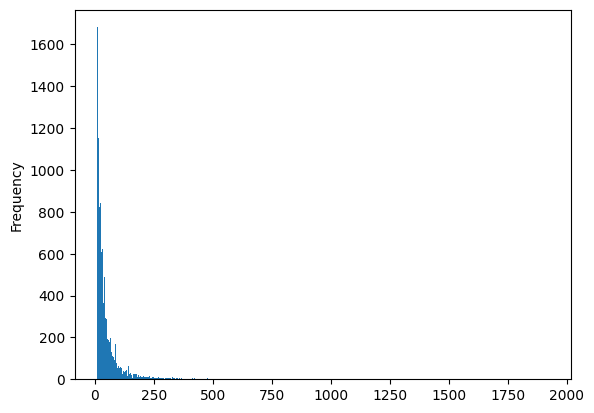

In [12]:
# df_users_times = df_events_view.groupby('resume_id')['event_datetime'].agg(lambda x: x.nunique()).reset_index()#['event_datetime'].plot.hist(bins=100)
# df_users_times[df_users_times['event_datetime']>=5]

df_users_times = df_events_view.groupby('resume_id')['job_id'].agg(lambda x: x.nunique()).reset_index().rename(columns={'job_id': 'num_job_ids'})

print(df_users_times['num_job_ids'].min(), df_users_times['num_job_ids'].max())
df_users_times['num_job_ids'].plot.hist(bins=1000)


<Axes: ylabel='Frequency'>

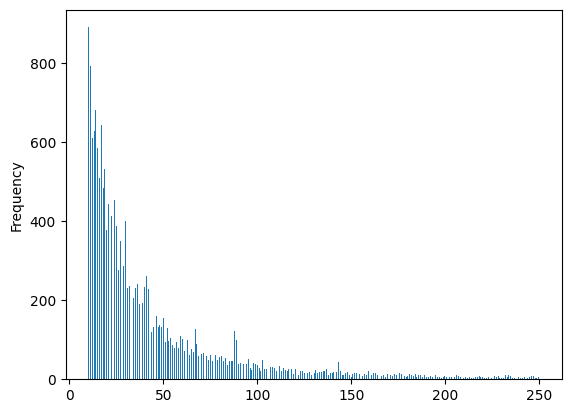

In [13]:
df_users_active = df_users_times[(df_users_times['num_job_ids'] >= min_num_job_ids) & (df_users_times['num_job_ids'] <= max_num_job_ids)].copy()
del df_users_times
df_users_active['num_job_ids'].plot.hist(bins=500)

In [14]:
df_users_active

,resume_id,num_job_ids
0,1,25
1,2,62
2,4,32
3,5,15
4,6,148
...,...,...
20154,394601,11
20155,394625,30
20156,394630,10
20157,394632,12


# Encode resume_ids and job_ids as `input_ids`

In [15]:
print('Before selecting the subsets:')
print(df_events['resume_id'].nunique())
print(df_events['job_id'].nunique())

del df_events

Before selecting the subsets:
20159
48207


Embedding sizes in the model

In [16]:
print('Num of unique users:', df_users_active['resume_id'].nunique())

df_events_view_active = df_events_view.loc[df_events_view['resume_id'].isin(df_users_active['resume_id'])].copy()
del df_events_view
print('Num of unique job ids:', df_events_view_active['job_id'].nunique())

Num of unique users: 19672
Num of unique job ids: 47844


encoding the resume_ids

In [17]:
from sklearn import preprocessing

le_resume_ids = preprocessing.LabelEncoder()
le_resume_ids.fit(df_users_active['resume_id'])

df_users_active['resume_id_encoded'] = le_resume_ids.transform(df_users_active['resume_id'])
df_events_view_active['resume_id_encoded'] = le_resume_ids.transform(df_events_view_active['resume_id'])

#----------------
print(df_users_active['resume_id_encoded'].min(), df_users_active['resume_id_encoded'].max(), df_events_view_active['resume_id_encoded'].min(), df_events_view_active['resume_id_encoded'].max())

# reserve 0th as padding
df_users_active['resume_id_encoded'] += 1
df_events_view_active['resume_id_encoded'] += 1

print(df_users_active['resume_id_encoded'].min(), df_users_active['resume_id_encoded'].max(), df_events_view_active['resume_id_encoded'].min(), df_events_view_active['resume_id_encoded'].max())


0 19671 0 19671
1 19672 1 19672


In [18]:
df_events_view_active['resume_id_encoded'].nunique(), df_users_active['resume_id_encoded'].nunique()

(19672, 19672)

encode the job_ids

In [19]:
le_job_ids = preprocessing.LabelEncoder()
le_job_ids.fit(df_events_view_active['job_id'])

df_events_view_active['job_id_encoded'] = le_job_ids.transform(df_events_view_active['job_id'])
print(df_events_view_active['job_id_encoded'].nunique())

df_ads_active = df_ads[df_ads['job_id'].isin(le_job_ids.classes_)].copy()
del df_ads
df_ads_active['job_id_encoded'] = le_job_ids.transform(df_ads_active['job_id'])
print(df_ads_active['job_id_encoded'].nunique())

df_job_id_popularity_active = df_job_id_popularity[df_job_id_popularity['job_id'].isin(le_job_ids.classes_)].copy()
del df_job_id_popularity
df_job_id_popularity_active['job_id_encoded'] = le_job_ids.transform(df_job_id_popularity_active['job_id'])
print(df_job_id_popularity_active['job_id_encoded'].nunique())

#----------------------------
print(df_events_view_active['job_id_encoded'].min(), df_events_view_active['job_id_encoded'].max())
# reserve 0th as padding
df_events_view_active['job_id_encoded'] += 1
df_ads_active['job_id_encoded'] += 1
df_job_id_popularity_active['job_id_encoded'] += 1
print(df_events_view_active['job_id_encoded'].min(), df_events_view_active['job_id_encoded'].max())

47844
47844
47844
0 47843
1 47844


In [20]:
assert df_users_active.resume_id.nunique() == df_users_active.resume_id_encoded.nunique()
assert df_events_view_active.resume_id.nunique() == df_events_view_active.resume_id_encoded.nunique()
assert df_events_view_active.job_id.nunique() == df_events_view_active.job_id_encoded.nunique()
assert df_ads_active.job_id.nunique() == df_ads_active.job_id_encoded.nunique()
assert df_job_id_popularity_active.job_id.nunique() == df_job_id_popularity_active.job_id_encoded.nunique()

In [21]:
df_users_active = df_users_active.drop(columns='resume_id')
df_events_view_active = df_events_view_active.drop(columns=['resume_id', 'job_id'])
df_ads_active = df_ads_active.drop(columns='job_id')
df_job_id_popularity_active = df_job_id_popularity_active.drop(columns='job_id')

In [22]:
# df_users_active
# df_events_view_active
# df_ads_active
# df_job_id_popularity_active

# Encode metadata of jobs, including location, etc.

In [23]:
metadata_cols = [x for x in df_ads_active.columns if x not in ['title', 'abstract', 'content']]
df_ads_active_metadata = df_ads_active[metadata_cols].copy()
df_ads_active_metadata

,location,classification,sub_classification,work_type,job_id_encoded
0,Sydney,Education & Training,Other,Full Time,23106
1,Melbourne,Retail & Consumer Products,Retail Assistants,Casual/Vacation,28362
2,Adelaide,Information & Communication Technology,Consultants,Full Time,31516
3,Melbourne,Real Estate & Property,"Commercial Sales, Leasing & Property Mgmt",Full Time,4217
4,Auckland,Information & Communication Technology,Management,Full Time,8791
...,...,...,...,...,...
49995,Sydney,Information & Communication Technology,Business/Systems Analysts,Full Time,4825
49996,Perth,Healthcare & Medical,Other,Full Time,17644
49997,Melbourne,"Manufacturing, Transport & Logistics","Warehousing, Storage & Distribution",Full Time,8407
49998,Coffs Harbour & North Coast,Trades & Services,Labourers,Casual/Vacation,20390


In [24]:
for c in df_ads_active_metadata.columns:
    if c == 'job_id_encoded' or str(c).endswith('_encoded'):
        continue

    le = preprocessing.LabelEncoder()
    le.fit(df_ads_active_metadata[c])
    df_ads_active_metadata[f'{c}_encoded'] = le.transform(df_ads_active_metadata[c])
    # reserve 0th as padding
    df_ads_active_metadata[f'{c}_encoded'] += 1
    df_ads_active_metadata = df_ads_active_metadata.drop(columns=c)
    print(c, le.classes_.size)

location 83
classification 30
sub_classification 305
work_type 4


In [27]:
for c in df_ads_active_metadata.columns:
    print(c, df_ads_active_metadata[c].nunique(), df_ads_active_metadata[c].min(), df_ads_active_metadata[c].max())

job_id_encoded 47844 1 47844
location_encoded 83 1 83
classification_encoded 30 1 30
sub_classification_encoded 305 1 305
work_type_encoded 4 1 4


In [28]:
df_ads_active_metadata.set_index(keys='job_id_encoded', verify_integrity=True)

,location_encoded,classification_encoded,sub_classification_encoded,work_type_encoded
job_id_encoded,,,,
23106,67,11,206,3
28362,46,25,251,1
31516,2,18,63,3
4217,46,24,58,3
8791,8,18,156,3
...,...,...,...,...
4825,67,18,41,3
17644,55,15,206,3
8407,46,21,298,3


In [29]:
jobs_metadata_output_path = '/root/projects/PythonProjects/ip-dual-encoder-factorization-machine/data/input_processed_output/' + 'jobs_metadata.csv'

df_ads_active_metadata.to_csv(jobs_metadata_output_path, index=False)


In [82]:
df_ads_active_metadata.set_index(keys='job_id_encoded', verify_integrity=True).to_dict().keys()

dict_keys(['location_encoded', 'classification_encoded', 'sub_classification_encoded', 'work_type_encoded'])

In [121]:
# pd.read_csv(jobs_metadata_output_path)['location_encoded']
# jobid_to_locationid = df_ads_active_metadata.set_index(keys='job_id_encoded', verify_integrity=True).to_dict()['location_encoded']
# jobid_to_locationid

# Generating Train, Validation, Test data

In [23]:
RESUME_ID_ENCODED = 'resume_id_encoded'
JOB_ID_ENCODED = 'job_id_encoded'

# A user example (Skip!)

In [36]:
example_resume_id = 10  #18  #11 #10 #3

df_example_resume_id = df_events_view_active[df_events_view_active[RESUME_ID_ENCODED] == example_resume_id].reset_index(drop=True)

display(df_example_resume_id)
df_example_resume_id['event_datetime'].unique()

,event_datetime,resume_id_encoded,job_id_encoded
0,2021-05-01 00:00:31,10,12990
1,2021-05-01 00:00:31,10,20891
2,2021-05-01 00:00:31,10,31713
3,2021-05-01 00:00:31,10,17810
4,2021-05-01 00:00:31,10,8450
5,2021-05-01 00:00:31,10,30068
6,2021-05-01 00:00:31,10,34134
7,2021-05-01 00:00:31,10,17834
8,2021-05-01 00:00:31,10,39531
9,2021-05-01 00:00:31,10,39316


array(['2021-05-01 00:00:31'], dtype=object)

In [37]:
positive_items_by_current_user = df_example_resume_id[JOB_ID_ENCODED].to_list()
len(positive_items_by_current_user)

23

Sequential job clicks by the example user

In [38]:
df_example_resume_id['job_id_sequence'] = None
df_example_resume_id['job_id_next'] = None

# tss = TimeSeriesSplit(test_size=1)#, test_size=2)
# for i, (x, y) in enumerate(tss.split(df_example_resume_id)):
#     print(i, x, y)

tss = TimeSeriesSplit(n_splits=len(df_example_resume_id.index) - 1, test_size=1)  #, test_size=2)
for i, (x, y) in enumerate(tss.split(df_example_resume_id)):
    print(
        i,
        x, '-->', y, '\t',
        x[-1], ':',
        df_example_resume_id.iloc[:x[-1] + 1][JOB_ID_ENCODED].tolist(), '-->', df_example_resume_id.iloc[y[-1]][JOB_ID_ENCODED]
    )
    df_example_resume_id.loc[df_example_resume_id.index == x[-1], 'job_id_sequence'] = str(df_example_resume_id.iloc[:x[-1] + 1][JOB_ID_ENCODED].tolist())
    df_example_resume_id.loc[df_example_resume_id.index == x[-1], 'job_id_next'] = df_example_resume_id.iloc[y[-1]][JOB_ID_ENCODED]
    df_example_resume_id.loc[df_example_resume_id.index == x[-1], 'class'] = 1


0 [0] --> [1] 	 0 : [12990] --> 20891
1 [0 1] --> [2] 	 1 : [12990, 20891] --> 31713
2 [0 1 2] --> [3] 	 2 : [12990, 20891, 31713] --> 17810
3 [0 1 2 3] --> [4] 	 3 : [12990, 20891, 31713, 17810] --> 8450
4 [0 1 2 3 4] --> [5] 	 4 : [12990, 20891, 31713, 17810, 8450] --> 30068
5 [0 1 2 3 4 5] --> [6] 	 5 : [12990, 20891, 31713, 17810, 8450, 30068] --> 34134
6 [0 1 2 3 4 5 6] --> [7] 	 6 : [12990, 20891, 31713, 17810, 8450, 30068, 34134] --> 17834
7 [0 1 2 3 4 5 6 7] --> [8] 	 7 : [12990, 20891, 31713, 17810, 8450, 30068, 34134, 17834] --> 39531
8 [0 1 2 3 4 5 6 7 8] --> [9] 	 8 : [12990, 20891, 31713, 17810, 8450, 30068, 34134, 17834, 39531] --> 39316
9 [0 1 2 3 4 5 6 7 8 9] --> [10] 	 9 : [12990, 20891, 31713, 17810, 8450, 30068, 34134, 17834, 39531, 39316] --> 6257
10 [ 0  1  2  3  4  5  6  7  8  9 10] --> [11] 	 10 : [12990, 20891, 31713, 17810, 8450, 30068, 34134, 17834, 39531, 39316, 6257] --> 9923
11 [ 0  1  2  3  4  5  6  7  8  9 10 11] --> [12] 	 11 : [12990, 20891, 31713, 1781

In [40]:
# Remove the last row that has no next item for prediction
df_example_resume_id_positive_items = df_example_resume_id.drop(index=df_example_resume_id.index[-1])

df_example_resume_id_positive_items

,event_datetime,resume_id_encoded,job_id_encoded,job_id_sequence,job_id_next,class
0,2021-05-01 00:00:31,10,12990,[12990],20891,1.0
1,2021-05-01 00:00:31,10,20891,"[12990, 20891]",31713,1.0
2,2021-05-01 00:00:31,10,31713,"[12990, 20891, 31713]",17810,1.0
3,2021-05-01 00:00:31,10,17810,"[12990, 20891, 31713, 17810]",8450,1.0
4,2021-05-01 00:00:31,10,8450,"[12990, 20891, 31713, 17810, 8450]",30068,1.0
5,2021-05-01 00:00:31,10,30068,"[12990, 20891, 31713, 17810, 8450, 30068]",34134,1.0
6,2021-05-01 00:00:31,10,34134,"[12990, 20891, 31713, 17810, 8450, 30068, 34134]",17834,1.0
7,2021-05-01 00:00:31,10,17834,"[12990, 20891, 31713, 17810, 8450, 30068, 3413...",39531,1.0
8,2021-05-01 00:00:31,10,39531,"[12990, 20891, 31713, 17810, 8450, 30068, 3413...",39316,1.0
9,2021-05-01 00:00:31,10,39316,"[12990, 20891, 31713, 17810, 8450, 30068, 3413...",6257,1.0


Popularity-biased Negative Sampling

In [42]:
# set_negative_items = set(df_job_id_popularity['job_id']) - set(df_example_resume_id['job_id'].values)
# print(len(set_negative_items))

df_negative_item_candidates = df_job_id_popularity_active[
    ~df_job_id_popularity_active[JOB_ID_ENCODED].isin(positive_items_by_current_user)]
df_negative_item_candidates

,num_resume_ids,num_resume_ids_pow2a,job_id_encoded
0,83,9.110434,1
1,28,5.291503,2
2,59,7.681146,3
3,2,1.414214,4
4,9,3.000000,5
...,...,...,...
48199,4,2.000000,47840
48200,13,3.605551,47841
48201,39,6.244998,47842
48202,2,1.414214,47843


In [43]:
# ratio_negative_to_positive_samples = 5
ratio_negative_to_positive_samples = 1

In [44]:
# train_ground_truth, valid_test_ground_truth = train_test_split(df_example_resume_id_positive_items, test_size=.4, shuffle=False)
# valid_ground_truth, test_ground_truth = train_test_split(valid_test_ground_truth, test_size=.5, shuffle=False)
# print(len(df_example_resume_id_positive_items.index), '--', len(train_ground_truth.index), len(valid_ground_truth.index), len(test_ground_truth.index))
# print('0.6?', len(train_ground_truth.index) / len(df_example_resume_id_positive_items.index))

In [49]:
# positive: train, valid, test
TRAIN_TEST_SPLIT_TEST_SIZE = 0.2
train_ground_truth, valid_test_ground_truth = train_test_split(df_example_resume_id_positive_items, test_size=TRAIN_TEST_SPLIT_TEST_SIZE, shuffle=False)
VALID_TEST_SPLIT_TEST_SIZE = 0.5
valid_ground_truth, test_ground_truth = train_test_split(valid_test_ground_truth, test_size=VALID_TEST_SPLIT_TEST_SIZE, shuffle=False)
for x in [train_ground_truth, valid_ground_truth, test_ground_truth]:
    display(x)

,event_datetime,resume_id_encoded,job_id_encoded,job_id_sequence,job_id_next,class
0,2021-05-01 00:00:31,10,12990,[12990],20891,1.0
1,2021-05-01 00:00:31,10,20891,"[12990, 20891]",31713,1.0
2,2021-05-01 00:00:31,10,31713,"[12990, 20891, 31713]",17810,1.0
3,2021-05-01 00:00:31,10,17810,"[12990, 20891, 31713, 17810]",8450,1.0
4,2021-05-01 00:00:31,10,8450,"[12990, 20891, 31713, 17810, 8450]",30068,1.0
5,2021-05-01 00:00:31,10,30068,"[12990, 20891, 31713, 17810, 8450, 30068]",34134,1.0
6,2021-05-01 00:00:31,10,34134,"[12990, 20891, 31713, 17810, 8450, 30068, 34134]",17834,1.0
7,2021-05-01 00:00:31,10,17834,"[12990, 20891, 31713, 17810, 8450, 30068, 3413...",39531,1.0
8,2021-05-01 00:00:31,10,39531,"[12990, 20891, 31713, 17810, 8450, 30068, 3413...",39316,1.0
9,2021-05-01 00:00:31,10,39316,"[12990, 20891, 31713, 17810, 8450, 30068, 3413...",6257,1.0


,event_datetime,resume_id_encoded,job_id_encoded,job_id_sequence,job_id_next,class
17,2021-05-01 00:00:31,10,30154,"[12990, 20891, 31713, 17810, 8450, 30068, 3413...",11814,1.0
18,2021-05-01 00:00:31,10,11814,"[12990, 20891, 31713, 17810, 8450, 30068, 3413...",13550,1.0


,event_datetime,resume_id_encoded,job_id_encoded,job_id_sequence,job_id_next,class
19,2021-05-01 00:00:31,10,13550,"[12990, 20891, 31713, 17810, 8450, 30068, 3413...",40708,1.0
20,2021-05-01 00:00:31,10,40708,"[12990, 20891, 31713, 17810, 8450, 30068, 3413...",27016,1.0
21,2021-05-01 00:00:31,10,27016,"[12990, 20891, 31713, 17810, 8450, 30068, 3413...",21303,1.0


In [50]:
negative_item_sampling_prob = df_negative_item_candidates['num_resume_ids_pow2a'] / df_negative_item_candidates['num_resume_ids_pow2a'].sum()

#data_split_dict = {'train': [train_ground_truth, train_negative_samples], 'valid': [valid_ground_truth, valid_negative_samples], 'test': [test_ground_truth, test_negative_samples]}
data_split_dict = {'train': [train_ground_truth], 'valid': [valid_ground_truth], 'test': [test_ground_truth]}

for k, v in data_split_dict.items():
    v.append(pd.concat([v[0].copy()] * ratio_negative_to_positive_samples))
    v[1]['job_id_next'] = np.random.choice(
        a=df_negative_item_candidates[JOB_ID_ENCODED],
        size=len(v[1].index),
        replace=False,
        p=negative_item_sampling_prob
    )  #negative_samples
    v[1]['class'] = 0

for k, v in data_split_dict.items():
    display(v[1])

,event_datetime,resume_id_encoded,job_id_encoded,job_id_sequence,job_id_next,class
0,2021-05-01 00:00:31,10,12990,[12990],35592,0
1,2021-05-01 00:00:31,10,20891,"[12990, 20891]",4530,0
2,2021-05-01 00:00:31,10,31713,"[12990, 20891, 31713]",8642,0
3,2021-05-01 00:00:31,10,17810,"[12990, 20891, 31713, 17810]",19828,0
4,2021-05-01 00:00:31,10,8450,"[12990, 20891, 31713, 17810, 8450]",18409,0
5,2021-05-01 00:00:31,10,30068,"[12990, 20891, 31713, 17810, 8450, 30068]",27392,0
6,2021-05-01 00:00:31,10,34134,"[12990, 20891, 31713, 17810, 8450, 30068, 34134]",44813,0
7,2021-05-01 00:00:31,10,17834,"[12990, 20891, 31713, 17810, 8450, 30068, 3413...",35825,0
8,2021-05-01 00:00:31,10,39531,"[12990, 20891, 31713, 17810, 8450, 30068, 3413...",40239,0
9,2021-05-01 00:00:31,10,39316,"[12990, 20891, 31713, 17810, 8450, 30068, 3413...",23330,0


,event_datetime,resume_id_encoded,job_id_encoded,job_id_sequence,job_id_next,class
17,2021-05-01 00:00:31,10,30154,"[12990, 20891, 31713, 17810, 8450, 30068, 3413...",37509,0
18,2021-05-01 00:00:31,10,11814,"[12990, 20891, 31713, 17810, 8450, 30068, 3413...",14870,0


,event_datetime,resume_id_encoded,job_id_encoded,job_id_sequence,job_id_next,class
19,2021-05-01 00:00:31,10,13550,"[12990, 20891, 31713, 17810, 8450, 30068, 3413...",26602,0
20,2021-05-01 00:00:31,10,40708,"[12990, 20891, 31713, 17810, 8450, 30068, 3413...",3980,0
21,2021-05-01 00:00:31,10,27016,"[12990, 20891, 31713, 17810, 8450, 30068, 3413...",24980,0


In [51]:
# data_split_dict['train'][0]['class'].value_counts()

In [57]:
# df_ads_active[['location', 'classification']]

In [52]:
train_examples = pd.concat(data_split_dict['train']).drop(columns=JOB_ID_ENCODED)
train_examples = train_examples.merge(df_ads_active[[JOB_ID_ENCODED, 'title', 'abstract']], left_on='job_id_next', right_on=JOB_ID_ENCODED).drop(columns=JOB_ID_ENCODED)

valid_examples = pd.concat(data_split_dict['valid']).drop(columns=JOB_ID_ENCODED)
valid_examples = valid_examples.merge(df_ads_active[[JOB_ID_ENCODED, 'title', 'abstract']], left_on='job_id_next', right_on=JOB_ID_ENCODED).drop(columns=JOB_ID_ENCODED)

test_examples = pd.concat(data_split_dict['test']).drop(columns=JOB_ID_ENCODED)
test_examples = test_examples.merge(df_ads_active[[JOB_ID_ENCODED, 'title', 'abstract']], left_on='job_id_next', right_on=JOB_ID_ENCODED).drop(columns=JOB_ID_ENCODED)


In [53]:
train_examples

,event_datetime,resume_id_encoded,job_id_sequence,job_id_next,class,title,abstract
0,2021-05-01 00:00:31,10,[12990],20891,1.0,Deputy Mining Manager,Beilby is seeking a highly skilled and experie...
1,2021-05-01 00:00:31,10,"[12990, 20891]",31713,1.0,Domestic Meat Trader,Do you want to work with one of Australia's fa...
2,2021-05-01 00:00:31,10,"[12990, 20891, 31713]",17810,1.0,Customer Care Agent (Customer Service Represen...,This is a Monday to Friday role which will be ...
3,2021-05-01 00:00:31,10,"[12990, 20891, 31713, 17810]",8450,1.0,Territory Manager QLD/NT,This is an exciting opportunity for a professi...
4,2021-05-01 00:00:31,10,"[12990, 20891, 31713, 17810, 8450]",30068,1.0,Human Resources Administrator,Bring your passion for People and creative fla...
5,2021-05-01 00:00:31,10,"[12990, 20891, 31713, 17810, 8450, 30068]",34134,1.0,Forklift Driver | Truganina Location,Looking for a new position in the new year? Lo...
6,2021-05-01 00:00:31,10,"[12990, 20891, 31713, 17810, 8450, 30068, 34134]",17834,1.0,Family Support Worker - Healthy Mothers Health...,As the leading public health service in the Ea...
7,2021-05-01 00:00:31,10,"[12990, 20891, 31713, 17810, 8450, 30068, 3413...",39531,1.0,Privacy Advisor,6 Month opportunity for a Privacy expert to ut...
8,2021-05-01 00:00:31,10,"[12990, 20891, 31713, 17810, 8450, 30068, 3413...",39316,1.0,Service Partner,The Service Partner works with the Customer Bu...
9,2021-05-01 00:00:31,10,"[12990, 20891, 31713, 17810, 8450, 30068, 3413...",6257,1.0,Quality Advisor,We are seeking an enthusiastic and dedicated Q...


In [34]:
test_examples['class'].value_counts()

class
0.0    25
1.0     5
Name: count, dtype: int64

# Generate train and test datasets (loop through all users)

In [24]:
def create_data_split(_ratio_negative_to_positive_samples: int):
    """
    Traverse all users and create the training and test datasets
    :return: (train_set, valid_set, test_set)
    """
    train_examples_users_list = []
    valid_examples_users_list = []
    test_examples_users_list = []

    for resume_id in tqdm(df_users_active[RESUME_ID_ENCODED].unique()):
        df_example_resume_id = df_events_view_active[df_events_view_active[RESUME_ID_ENCODED] == resume_id].reset_index(drop=True)

        positive_items_by_current_user = df_example_resume_id[JOB_ID_ENCODED].to_list()

        #Sequential clicks by the example user
        df_example_resume_id['job_id_sequence'] = None
        df_example_resume_id['job_id_next'] = None

        tss = TimeSeriesSplit(n_splits=len(df_example_resume_id.index) - 1, test_size=1)  #, test_size=2)
        for i, (x, y) in enumerate(tss.split(df_example_resume_id)):
            # print(
            #     i,
            #     x, '-->', y, '\t',
            #     x[-1], ':',
            #     df_example_resume_id.iloc[:x[-1] + 1]['job_id'].tolist(), '-->', df_example_resume_id.iloc[y[-1]]['job_id']
            # )
            df_example_resume_id.loc[df_example_resume_id.index == x[-1], 'job_id_sequence'] = str(df_example_resume_id.iloc[:x[-1] + 1][JOB_ID_ENCODED].tolist())
            df_example_resume_id.loc[df_example_resume_id.index == x[-1], 'job_id_next'] = df_example_resume_id.iloc[y[-1]][JOB_ID_ENCODED]
            df_example_resume_id.loc[df_example_resume_id.index == x[-1], 'class'] = 1

        # Remove the last row that has no next item for prediction
        df_example_resume_id_positive_items = df_example_resume_id.drop(index=df_example_resume_id.index[-1])

        #Popularity-biased Negative Sampling
        df_negative_item_candidates = df_job_id_popularity_active[
            ~df_job_id_popularity_active[JOB_ID_ENCODED].isin(positive_items_by_current_user)]

        # ratio_negative_to_positive_samples = 5

        # positive: train, valid, test
        TRAIN_TEST_SPLIT_TEST_SIZE = 0.2
        VALID_TEST_SPLIT_TEST_SIZE = 0.5
        train_ground_truth, valid_test_ground_truth = train_test_split(df_example_resume_id_positive_items, test_size=TRAIN_TEST_SPLIT_TEST_SIZE, shuffle=False)
        valid_ground_truth, test_ground_truth = train_test_split(valid_test_ground_truth, test_size=VALID_TEST_SPLIT_TEST_SIZE, shuffle=False)

        negative_item_sampling_prob = df_negative_item_candidates['num_resume_ids_pow2a'] / df_negative_item_candidates['num_resume_ids_pow2a'].sum()

        data_split_dict = {'train': [train_ground_truth], 'valid': [valid_ground_truth], 'test': [test_ground_truth]}
        # Generate negative samples
        for k, v in data_split_dict.items():
            v.append(pd.concat([v[0].copy()] * _ratio_negative_to_positive_samples))
            v[1]['job_id_next'] = np.random.choice(
                a=df_negative_item_candidates[JOB_ID_ENCODED],
                size=len(v[1].index),
                replace=False,
                p=negative_item_sampling_prob
            )  #negative_samples
            v[1]['class'] = 0

        train_examples = pd.concat(data_split_dict['train']).drop(columns=JOB_ID_ENCODED)
        train_examples = train_examples.merge(df_ads_active[[JOB_ID_ENCODED, 'title', 'abstract', 'location', 'classification']], left_on='job_id_next', right_on=JOB_ID_ENCODED).drop(columns=JOB_ID_ENCODED)

        valid_examples = pd.concat(data_split_dict['valid']).drop(columns=JOB_ID_ENCODED)
        valid_examples = valid_examples.merge(df_ads_active[[JOB_ID_ENCODED, 'title', 'abstract', 'location', 'classification']], left_on='job_id_next', right_on=JOB_ID_ENCODED).drop(columns=JOB_ID_ENCODED)

        test_examples = pd.concat(data_split_dict['test']).drop(columns=JOB_ID_ENCODED)
        test_examples = test_examples.merge(df_ads_active[[JOB_ID_ENCODED, 'title', 'abstract', 'location', 'classification']], left_on='job_id_next', right_on=JOB_ID_ENCODED).drop(columns=JOB_ID_ENCODED)

        train_examples_users_list.append(train_examples)
        valid_examples_users_list.append(valid_examples)
        test_examples_users_list.append(test_examples)

    return pd.concat(train_examples_users_list).reset_index(drop=True), pd.concat(valid_examples_users_list).reset_index(drop=True), pd.concat(test_examples_users_list).reset_index(drop=True)



In [25]:
train_data, valid_data, test_data = create_data_split(_ratio_negative_to_positive_samples=1)

  0%|          | 0/19672 [00:00<?, ?it/s]

In [26]:
train_data[RESUME_ID_ENCODED].nunique(), valid_data[RESUME_ID_ENCODED].nunique(), test_data[RESUME_ID_ENCODED].nunique()

(19672, 19672, 19672)

# SAVE

In [27]:
output_path = '/root/projects/PythonProjects/ip-dual-encoder-factorization-machine/data/input_processed_output/'
file_out = output_path + 'train_data.json'
train_data.to_json(file_out)

file_out = output_path + 'valid_data.json'
valid_data.to_json(file_out)

file_out = output_path + 'test_data.json'
test_data.to_json(file_out)

In [28]:
len(train_data.index), len(valid_data.index), len(test_data.index)

(1344086, 168038, 187480)

## Verify the class ratio

In [2]:
import pandas as pd
output_path = '/root/projects/PythonProjects/ip-dual-encoder-factorization-machine/data/input_processed_output/' + 'train_data.json'
df_train = pd.read_json(output_path)
df_train

,event_datetime,resume_id_encoded,job_id_sequence,job_id_next,class,title,abstract,location,classification
0,2021-05-01 00:00:07,1,[23106],17225,1,"Programme Manager, healthAlliance","Permanent, Full Time Role Based in Penrose",Auckland,Information & Communication Technology
1,2021-05-01 00:00:07,1,"[23106, 17225]",939,1,Office Administrator,Excellent opportunity for a proactive PA/Offic...,Sydney,Administration & Office Support
2,2021-05-01 00:00:07,1,"[23106, 17225, 939]",24851,1,2IC Retail Career Opportunity - Liverpool Store,High profile Homemaker Retailer specialising i...,Sydney,Retail & Consumer Products
3,2021-05-01 00:00:07,1,"[23106, 17225, 939, 24851]",20479,1,Maternal & Child Health Nurse,Yarra City Council is looking for enthusiastic...,Melbourne,Government & Defence
4,2021-05-01 00:00:07,1,"[23106, 17225, 939, 24851, 20479]",44011,1,Construction All Rounder / Labourer,Construction All Rounder/Labourer - Fulltime C...,Toowoomba & Darling Downs,Trades & Services
...,...,...,...,...,...,...,...,...,...
1344081,2021-05-01 23:54:48,19672,"[18229, 25037, 24828, 19224, 27766, 5343, 1579...",14325,0,REAL ESTATE SALES - STAR PERFORMER WANTED - BE...,Berwick Leading Agents Expected Income Earning...,Melbourne,Sales
1344082,2021-05-01 23:54:48,19672,"[18229, 25037, 24828, 19224, 27766, 5343, 1579...",27777,0,Litigation Support Clerk (afternoon shift),Afternoon shift loading $$,Sydney,Administration & Office Support
1344083,2021-05-01 23:54:48,19672,"[18229, 25037, 24828, 19224, 27766, 5343, 1579...",45281,0,Team Administrator,Dynamic role working within a passionate and s...,Auckland,Administration & Office Support
1344084,2021-05-01 23:54:48,19672,"[18229, 25037, 24828, 19224, 27766, 5343, 1579...",43618,0,Retail Second In Charge - David Jones Chadston...,"Join Seed on your exciting new journey; Help, ...",Melbourne,Retail & Consumer Products


In [4]:
df_train['class'].value_counts(dropna=False).to_dict()

{1: 672043, 0: 672043}

# COPY to S3

In [29]:
# !aws s3 cp /root/projects/PythonProjects/ip-dual-encoder-factorization-machine/data/input_processed_output/ s3://tyler-s3-bucket/other/interview-projects/seek/input_processed_output/ --recursive

In [30]:
'Done'

'Done'

# Use the following numbers as the embedding sizes (vocab) in the model

In [31]:
print('Num of unique users:', df_users_active['resume_id_encoded'].nunique())
print('Num of unique job ids:', df_events_view_active['job_id_encoded'].nunique())

Num of unique users: 19672
Num of unique job ids: 47844


In [32]:
df_events_view_active['resume_id_encoded'].nunique()

19672